# Reinforcement Learning Assignment: Easy21

Solution to Easy21, the [assignment](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf) from David Silver's UCL reinforcement learning [lectures](https://www.davidsilver.uk/teaching/). 

In [1]:
#
# Global definition and common tools.
#

import random
import numpy as np


# global random seed
RANDOM_SEED = 20200403

# definitions:
# p_sum: sum of player's cards (added black cards and subtracted red cards), valid range [1,21];
#        below 1 or above 21 are considered burst which means player loses the game.
# d_value: the value of dealer's first card, valid range [1,10].
# state is simply a (p_sum, d_value) tuple.
# action: stick 0, hit 1.
# reward: player win +1, player lose -1, others 0 (draw or the game is not finished).
# q_tensor: a 3D tensor (numpy.ndarray indexing convention) representing Q(s,a) and N(s,a) values for each unique (s,a) pair;
#           its dimensions are 4*21*10, explained as below:
#     q_tensor[0,p-1,d-1] - Q((p,d), stick)
#     q_tensor[1,p-1,d-1] - Q((p,d), hit)
#     q_tensor[2,p-1,d-1] - N((p,d), stick)
#     q_tensor[3,p-1,d-1] - N((p,d), hit)

def q_get(q_tensor, p_sum, d_value, action=None):
    if None == action:
        return np.max(q_tensor[:2, p_sum-1, d_value-1])
    else:
        return q_tensor[action, p_sum-1, d_value-1]

def q_set(q_tensor, p_sum, d_value, action, q_value):
    q_tensor[action, p_sum-1, d_value-1] = q_value

# if action=None, return N(s) which is exactly N(s,stick)+N(s,hit).
def n_get(q_tensor, p_sum, d_value, action=None):
    if None == action:
        return q_tensor[2:, p_sum-1, d_value-1].sum()
    else:
        return q_tensor[action+2, p_sum-1, d_value-1]

def n_set(q_tensor, p_sum, d_value, action, n):
    q_tensor[action+2, p_sum-1, d_value-1] = n

def n_inc(q_tensor, p_sum, d_value, action):
    q_tensor[action+2, p_sum-1, d_value-1] += 1

# return initial state (p_sum, d_value).
def init():
    return (random.randint(1, 10), random.randint(1, 10))

# deal 1 card (1/3 for red card, otherwise black card).
def deal():
    return random.randint(1, 10) * (-1 if (random.random() < 1.0/3) else 1)

# given the deal's value, play out to the end of the game, return the final value of the dealer.
# return -1 if the dealer bursts.
def playout(d_value):
    while d_value >= 1 and d_value < 17:
        d_value += deal()
    if d_value < 1 or d_value > 21:  # dealer bursts
        d_value = -1
    return d_value

# an epsilon-greedy strategy with epsilon=explore_factor / (explore_factor+N(s)), i.e.,
# chooses random action with probability epsilon and chooses argmax_a Q(s,a) with probability (1-epsilon).
# return 0 for stick and 1 for hit.
def policy(q_tensor, p_sum, d_value, explore_factor=100):
    n = n_get(q_tensor, p_sum, d_value)
    epsilon = (1.0 * explore_factor) / (explore_factor + n)
    if random.random() < epsilon:  # explore
        return random.randint(0, 1)
    else:  # greedy
        #return np.argmax([q_get(q_tensor, p_sum, d_value, 0), q_get(q_tensor, p_sum, d_value, 1)])
        # hack for performance
        return np.argmax(q_tensor[:2, p_sum-1, d_value-1])

# takes in a state (p_sum, d_value) and action, return a tuple of (next-state, reward);
# if player's action=stick, the dealer will play out to the end of the game.
# the returnd next-state would be (-1, -1) when the game is terminated.
def step(p_sum, d_value, action):
    reward = 0  # 0 for draw game or non-terminated state
    if 0 == action:  # stick
        d_value = playout(d_value)
        if -1 == d_value:  # dealer bursts, player wins
            reward = 1
        elif p_sum < d_value:  # player loses
            reward = -1
        elif p_sum > d_value:  # player wins
            reward = 1
        p_sum = d_value = -1  # game terminated
    else:  # hit
        p_sum += deal()
        if p_sum < 1 or p_sum > 21:  # player bursts
            p_sum = d_value = -1  # game terminated
            reward = -1  # player loses
    return ((p_sum, d_value), reward)

# generate a complete episode from the initial state with the given policy.
# policy is a callable like func(p_sum, d_value)->action
# return a list with the format: [(s1, a1, r2), (s2, a2, r2),...,(sT,dummy,dummy)] which sT is the terminate state (-1,-1).
def episode(p_sum, d_value, policy):
    ret = []
    while not (-1 == p_sum or -1 == d_value):
        action = policy(p_sum, d_value)
        next_state, reward = step(p_sum, d_value, action)
        ret.append(((p_sum, d_value), action, reward))
        p_sum, d_value = next_state
    ret.append(((-1, -1), 0, 0))  # push the terminated state, dummy action and reward
    return ret

In [2]:
# Question 1 is answered in the previous code block, check function "step".
# Question 2: Monte-Carlo Control

import functools


def policy_with_q_tensor(q_tensor, explore_factor=100):
    def inner(func):
        @functools.wraps(func)
        def wrap(p_sum, d_value):
            return func(q_tensor, p_sum, d_value, explore_factor=explore_factor)
        return wrap
    return inner


# Monte-Carlo control, the q_tensor will be modified to reflect the resulted Q values.
# q_tensor: should be initialised before passed in, will be modified to store the results.
# n_episodes: how many episodes to run.
# policy: a callable like func(p_sum, d_value)->action
# return the win rate of the player
def mc_run(q_tensor, n_episodes, policy):
    wins = []
    for k in range(n_episodes):
        state0 = init()
        ep = episode(state0[0], state0[1], policy)
        returns = [e[2] for e in ep]
        wins.append(1 == returns[-2])  # the [-1] is dummy reward, the [-2] is the true reward of the episode.
        # print(f'episode {k}: {ep}.')
        for t, ((p_, d_), a_, r_) in enumerate(ep):
            # print(f'step {t}: ({p_}, {d_}), {a_}, {r_}.')
            if -1 == p_ or -1 == d_:  # terminated
                break
            # update N(s,a)
            n_inc(q_tensor, p_, d_, a_)
            n = n_get(q_tensor, p_, d_, a_)
            # update Q(s,a)
            q = q_get(q_tensor, p_, d_, a_)
            q += (1.0 / n) * (np.sum(returns[t:]) - q)
            q_set(q_tensor, p_, d_, a_, q)
    return np.mean(wins)

In [3]:
random.seed(RANDOM_SEED)

mc_q_tensor = np.zeros((4, 21, 10))
egreedy_policy = policy_with_q_tensor(mc_q_tensor, explore_factor=150)(policy)
prev_n = 0
prev_winrate = 0.0

for n in (1000, 5000, 10000, 20000, 50000, 70000, 100000, 200000):
    winrate = mc_run(mc_q_tensor, n - prev_n, egreedy_policy)
    # accumulated win rate
    winrate = (prev_winrate * prev_n + winrate * (n - prev_n)) / n
    print(f'win-rate for {n} episodes: {winrate:.4f}.')
    prev_n = n
    prev_winrate = winrate

win-rate for 1000 episodes: 0.4510.
win-rate for 5000 episodes: 0.4580.
win-rate for 10000 episodes: 0.4641.
win-rate for 20000 episodes: 0.4767.
win-rate for 50000 episodes: 0.4941.
win-rate for 70000 episodes: 0.4984.
win-rate for 100000 episodes: 0.5042.
win-rate for 200000 episodes: 0.5108.


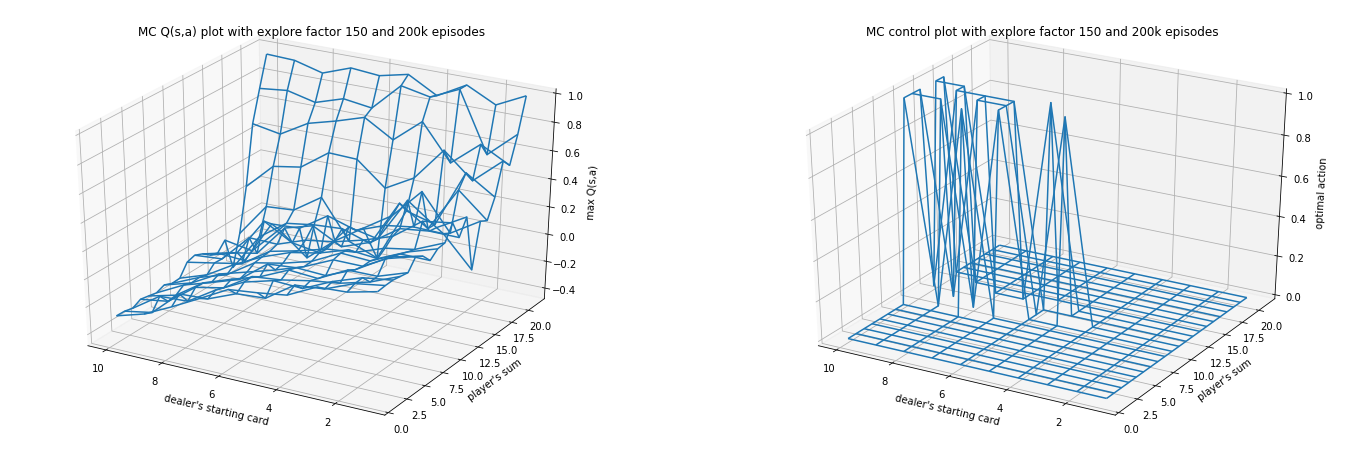

In [4]:
# different explore factors 30, 50, 100, 120, 150 and 200 are tested with fixed random seed and number of episodes,
# the best factor is 50, however, factor 150 produces the most smooth state value plot, so I use it as below.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# the code below plots 3d bar chart

#shape = mc_q_tensor.shape
#
# max_a Q(s,a)
#q_points = np.array([[d, p, np.max([q_get(mc_q_tensor, p, d, 0), q_get(mc_q_tensor, p, d, 1)])] \
#                     for p in range(1, shape[1]+1) for d in range(1, shape[2]+1)])
# argmax_a Q(s,a)
#a_points = np.array([[d, p, np.argmax([q_get(mc_q_tensor, p, d, 0), q_get(mc_q_tensor, p, d, 1)])] \
#                     for p in range(1, shape[1]+1) for d in range(1, shape[2]+1)])
#
#fig = plt.figure(figsize=(15, 5))
#
#ax1 = fig.add_subplot(121, projection='3d')
#bar_bottom = np.min(q_points[:,2])
#ax1.bar3d(q_points[:,0], q_points[:,1], bar_bottom * np.ones_like(q_points[:,2]), \
#          1, 1, q_points[:,2] - bar_bottom, shade=True)
#ax2 = fig.add_subplot(122, projection='3d')
#ax2.bar3d(a_points[:,0], a_points[:,1], np.zeros_like(a_points[:,2]), 1, 1, a_points[:,2], shade=True)
#ax2.set_title('MC policy plot with explore factor 50 and 200k episodes')
#ax2.set_xlabel('dealer\'s starting card')
#ax2.set_ylabel('player\'s sum')
#ax2.set_zlabel('optimal action (stick-0, hit-1)')
#
#plt.show()


# the code below plot the wireframe chart (refer to: https://github.com/kvfrans/Easy21-RL/blob/master/plots.py)

fig = plt.figure(figsize=(24, 8))

ax1 = fig.add_subplot(121, projection='3d')
x, y = np.meshgrid(range(1, 11), range(1, 22))
z = np.array([q_get(mc_q_tensor, p, d) for (d, p) in zip(x.ravel(), y.ravel())]).reshape(x.shape)
ax1.plot_wireframe(x, y, z)
ax1.invert_xaxis()
ax1.set_title('MC Q(s,a) plot with explore factor 150 and 200k episodes')
ax1.set_xlabel('dealer\'s starting card')
ax1.set_ylabel('player\'s sum')
ax1.set_zlabel('max Q(s,a)')

ax2 = fig.add_subplot(122, projection='3d')
z = np.array([np.argmax(mc_q_tensor[:2, p-1, d-1]) for (d, p) in zip(x.ravel(), y.ravel())]).reshape(x.shape)
ax2.plot_wireframe(x, y, z)
ax2.invert_xaxis()
ax2.set_title('MC control plot with explore factor 150 and 200k episodes')
ax2.set_xlabel('dealer\'s starting card')
ax2.set_ylabel('player\'s sum')
ax2.set_zlabel('optimal action')

plt.show()

In [5]:
# Question 3: backward-view SARSA(lambda) with eligibility traces.

# using a 3d tensor (numpy.ndarray) for eligibility traces, with the format below:
# dimension 2*21*10
# e_tensor[0,p_sum-1,d_value-1]: eligibility trace for state (p_sum, d_value) action 'stick'
# e_tensor[1,p_sum-1,d_value-1]: eligibility trace for state (p_sum, d_value) action 'hit'

import itertools


def etrace_get(e_tensor, p_sum, d_value, action):
    return e_tensor[action, p_sum-1, d_value-1]

def etrace_inc(e_tensor, p_sum, d_value, action):
    e_tensor[action, p_sum-1, d_value-1] += 1

def etrace_set(e_tensor, p_sum, d_value, action, e):
    e_tensor[action, p_sum-1, d_value-1] = e

# return iterator for enumerating all state (p_sum, d_value) indexes (1-21, 1-10).
# return iterator for enumerating all ((p_sum, d_value), action) if include_action=True
def iter_state(include_action=False):
    p, d = map(np.ravel, np.meshgrid(range(1, 22), range(1, 11)))
    if include_action:
        return itertools.product(zip(p, d), (0, 1))
    else:
        return zip(p, d)

# return list of max Q(s,a) over all (s,a), the returned order is specified by iter_state()
def q_getall(q_tensor):
    #return np.array([np.max([q_get(q_tensor, p, d, 0), q_get(q_tensor, p, d, 1)]) for (p, d) in iter_state()])
    return np.max(q_tensor[:2], axis=0).ravel()

# q_tensor: 2*21*10 ndarray for Q(s,a), must be initialised
# lambda_: TD factor
# n_episodes: episodes to train
# policy: callable (p_sum, d_value)->action
# mse_func: callable ([Q(s,a) over all (s,a)]) -> mean-squared error (compared to "correct" Q values) over all Q(s,a)
# return (win-rate of the player, [mean-squared error per episode])
def sarsa_run(q_tensor, lambda_, n_episodes, policy, mse_func=None):
    wins = []
    mse_episodes = []
    
    for k in range(n_episodes):
        # initialise eligibility traces for every episode
        e_tensor = np.zeros((2, 21, 10))
        
        # state 0
        p, d = init()
        a = policy(p, d)
        n_inc(q_tensor, p, d, a)
        
        while not (-1 == p or -1 == d):
            (p2, d2), r = step(p, d, a)
            
            q2_value = 0.0  # Q value for next state, 0.0 for the terminated.
            a2 = 0  # default action 0, so the terminated state also has an "action"
            if not (-1 == p2 or -1 == d2):  # not terminated
                a2 = policy(p2, d2)
                n_inc(q_tensor, p2, d2, a2)
                q2_value = q_get(q_tensor, p2, d2, a2)
            else:
                wins.append(1 == r)
            
            delta = r + q2_value - q_get(q_tensor, p, d, a)
            etrace_inc(e_tensor, p, d, a)
            
            # too many iterations, may be very slow
            #for (p_, d_), a_ in iter_state(include_action=True):
            #    n_ = n_get(q_tensor, p_, d_, a_)
            #    alpha = (0.0 if n_ < 1 else (1.0 / n_))
            #    e_ = etrace_get(e_tensor, p_, d_, a_)
            #    new_q = q_get(q_tensor, p_, d_, a_) + alpha * delta * e_
            #    q_set(q_tensor, p_, d_, a_, new_q)
            #    etrace_set(e_tensor, p_, d_, a_, lambda_ * e_)
            
            # batch method, borrowed from kvfrans' solution
            # trick (avoid dividing zero) for calculating alpha in batch
            q_tensor[2:][q_tensor[2:] < 1] = -1
            alpha = 1.0 / q_tensor[2:]
            alpha[alpha < 0] = 0.0
            q_tensor[2:][q_tensor[2:] < 1] = 0
                
            q_tensor[:2] += alpha * delta * e_tensor
            e_tensor *= lambda_
            
            p, d, a = p2, d2, a2
        
        if mse_func:
            mse_episodes.append(mse_func(q_getall(q_tensor)))

    return (np.mean(wins), mse_episodes)

In [6]:
# mean-squared error
def mse(arr1, arr2):
    return (np.square(arr1 - arr2)).mean()

def mse_q_wrapper(target_q_array):
    def _inner(q_array):
        return mse(q_array, target_q_array)
    return _inner


random.seed(RANDOM_SEED)

n_episodes = 100000
# MSE compared to previous MC results
mse_func = mse_q_wrapper(q_getall(mc_q_tensor))
# [(lambda, win-rate, mse list of episodes), ...]
sarsa_results = []

for lambda_ in map(lambda x: 0.1 * x, range(0, 11)):
    sarsa_q_tensor = np.zeros((4, 21, 10))
    # explore factor 50 makes it be greedy earlier
    sarsa_policy = policy_with_q_tensor(sarsa_q_tensor, explore_factor=50)(policy)
    winrate, mse_episodes = sarsa_run(sarsa_q_tensor, lambda_, n_episodes, sarsa_policy, mse_func=mse_func)
    sarsa_results.append((lambda_, winrate, mse_episodes))
    print(f'lambda {lambda_:.1f}, win-rate {winrate:.4f}, MSE (last episode) {mse_episodes[-1]:.4f}')

lambda 0.0, win-rate 0.5128, MSE (last episode) 0.0121
lambda 0.1, win-rate 0.5086, MSE (last episode) 0.0095
lambda 0.2, win-rate 0.5120, MSE (last episode) 0.0161
lambda 0.3, win-rate 0.5120, MSE (last episode) 0.0188
lambda 0.4, win-rate 0.5130, MSE (last episode) 0.0104
lambda 0.5, win-rate 0.5148, MSE (last episode) 0.0150
lambda 0.6, win-rate 0.5127, MSE (last episode) 0.0201
lambda 0.7, win-rate 0.5095, MSE (last episode) 0.0151
lambda 0.8, win-rate 0.5111, MSE (last episode) 0.0180
lambda 0.9, win-rate 0.5106, MSE (last episode) 0.0110
lambda 1.0, win-rate 0.5120, MSE (last episode) 0.0194


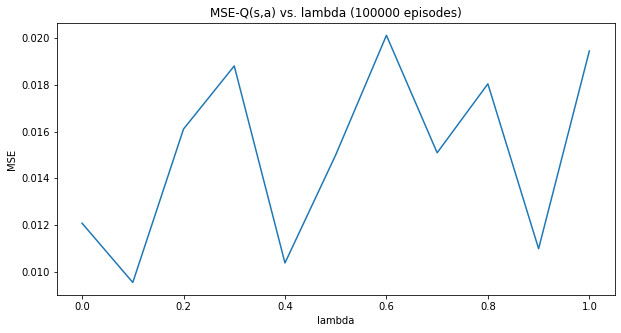

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot([t[0] for t in sarsa_results], [t[2][-1] for t in sarsa_results])
ax.set_title(f'MSE-Q(s,a) vs. lambda ({n_episodes} episodes)')
ax.set_xlabel('lambda')
ax.set_ylabel('MSE')

plt.show()

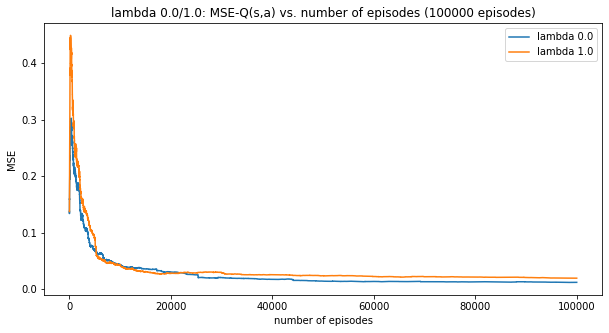

In [20]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.plot(range(1, n_episodes+1), sarsa_results[0][2], label='lambda 0.0')
ax.plot(range(1, n_episodes+1), sarsa_results[-1][2], label='lambda 1.0')

ax.set_title(f'lambda 0.0/1.0: MSE-Q(s,a) vs. number of episodes ({n_episodes} episodes)')
ax.set_xlabel('number of episodes')
ax.set_ylabel('MSE')

plt.legend(loc='upper right')
plt.show()

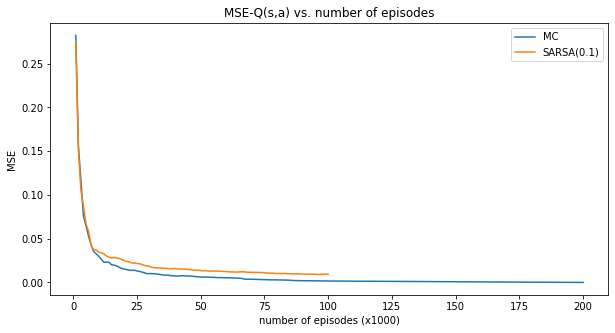

In [21]:
# Do another MC to see how it converges to the 200k results (MSE against the previous 200k-episodes MC).

random.seed(RANDOM_SEED)

mc2_q_tensor = np.zeros((4, 21, 10))
mc2_policy = policy_with_q_tensor(mc2_q_tensor, explore_factor=150)(policy)
mc2_mse = []

prev_n = 0
for n in range(1000, 200001, 1000):
    mc_run(mc2_q_tensor, n - prev_n, mc2_policy)
    prev_n = n
    mc2_mse.append(mse_func(q_getall(mc2_q_tensor)))

    
# From the above sarsa_results we can tell that: the best lambda for backward-view SARSA(lambda) is 0.1,
# which achieved MSE 0.0095 over 100k episodes, compared to the reference (200k-episodes MC).
# I plot both mc2 MSE and SARSA(0.1) MSE on the same graph, see what we can learn from.

sarsa_mse = np.array(sarsa_results[1][2])[list(range(999, 100000, 1000))]  # sampling every 1000 episodes

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.plot(range(1, len(mc2_mse)+1), mc2_mse, label='MC')
ax.plot(range(1, len(sarsa_mse)+1), sarsa_mse, label='SARSA(0.1)')

ax.set_title(f'MSE-Q(s,a) vs. number of episodes')
ax.set_xlabel('number of episodes (x1000)')
ax.set_ylabel('MSE')

plt.legend(loc='upper right')
plt.show()

# When we check the win-rate from both MC and SARSA results, we see that SARSA did better,
# it easily passed 50% before reaching 100k episodes trained, and the final win-rate is also greater than the 200k-episodes one.

In [10]:
# Question 4: SARSA(lambda) with linear function approximation

# map (s,a) to a 36-features binary vector.
def feature_binary(p_sum, d_value, action):
    if (p_sum, d_value, action) in feature_binary.cache:
        return feature_binary.cache[(p_sum, d_value, action)]
    
    d = [int(d_value >= t[0] and d_value <= t[1]) for t in ((1, 4), (4, 7), (7, 10))]
    p = [int(p_sum >= t[0] and p_sum <= t[1]) for t in ((1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21))]
    a = (1, 0) if 1 == action else (0, 1)
    ret = np.array(list(itertools.product(d, p, a)))
    ret = (np.sum(ret, axis=1) == 3).astype(int)
    
    feature_binary.cache[(p_sum, d_value, action)] = ret
    return ret
feature_binary.cache = {}  # "static variable" inside the above funciton

# do Q(s,a) approximation with linear function, params is an array of 36 float values.
def q_approx(p_sum, d_value, action, params):
    return np.dot(feature_binary(p_sum, d_value, action), params)

# running SARSA(lambda) with linear function approximation; params should be initialised properly before being passed in.
# lfa_func is callable: (p_sum, d_value, action, params)->q_value
# params will be modified during iteration
# return (win-rate of the player, [mean-squared error per episode])
def sarsa_lfa_run(lambda_, n_episodes, lfa_func, params, mse_func=None, epsilon=0.05, step_size=0.01):
    wins = []
    mse_episodes = []
    
    def _policy(p_sum, d_value):
        if random.random() <= epsilon:
            return random.randint(0, 1)
        else:
            return np.argmax([lfa_func(p_sum, d_value, 0, params), lfa_func(p_sum, d_value, 1, params)])
    
    # return the list of Q values in the same order of mc_q_tensor.ravel()
    def _q_all_lfa():
        g1, g2 = map(np.ravel, np.meshgrid(range(1, 11), range(1, 22)))
        return np.array([np.max([lfa_func(p, d, 0, params), lfa_func(p, d, 1, params)]) for (p, d) in zip(g2, g1)])
    
    for k in range(n_episodes):
        etraces = np.zeros(36)
        
        p, d = init()
        a = _policy(p, d)
        
        while not (-1 == p or -1 == d):
            (p2, d2), r = step(p, d, a)
            
            q2_value = 0.0
            a2 = 0
            if not (-1 == p2 or -1 == d2):
                a2 = _policy(p2, d2)
                q2_value = lfa_func(p2, d2, a2, params)
            else:
                wins.append(1 == r)
            
            delta = r + q2_value - lfa_func(p, d, a, params)
            etraces = lambda_ * etraces + feature_binary(p, d, a)
            params += step_size * delta * etraces
            
            p, d, a = p2, d2, a2
        
        if mse_func:
            mse_episodes.append(mse_func(_q_all_lfa()))
    
    return (np.mean(wins), mse_episodes)        

In [13]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

params0 = np.random.rand(36)
n_episodes = 100000
sarsa_lfa_results = []

for lambda_ in map(lambda x: 0.1 * x, range(0, 11)):
    winrate, mse_episodes = sarsa_lfa_run(lambda_, n_episodes, q_approx, params0.copy(), mse_func=mse_func)
    sarsa_lfa_results.append((lambda_, winrate, mse_episodes))
    print(f'lambda {lambda_:.1f}, win-rate {winrate:.4f}, MSE (last episode) {mse_episodes[-1]:.4f}')

lambda 0.0, win-rate 0.5118, MSE (last episode) 0.0516
lambda 0.1, win-rate 0.5118, MSE (last episode) 0.0329
lambda 0.2, win-rate 0.5130, MSE (last episode) 0.0418
lambda 0.3, win-rate 0.5139, MSE (last episode) 0.0345
lambda 0.4, win-rate 0.5141, MSE (last episode) 0.0368
lambda 0.5, win-rate 0.5175, MSE (last episode) 0.0389
lambda 0.6, win-rate 0.5173, MSE (last episode) 0.0381
lambda 0.7, win-rate 0.5147, MSE (last episode) 0.0311
lambda 0.8, win-rate 0.5142, MSE (last episode) 0.0325
lambda 0.9, win-rate 0.5188, MSE (last episode) 0.0347
lambda 1.0, win-rate 0.5182, MSE (last episode) 0.0486


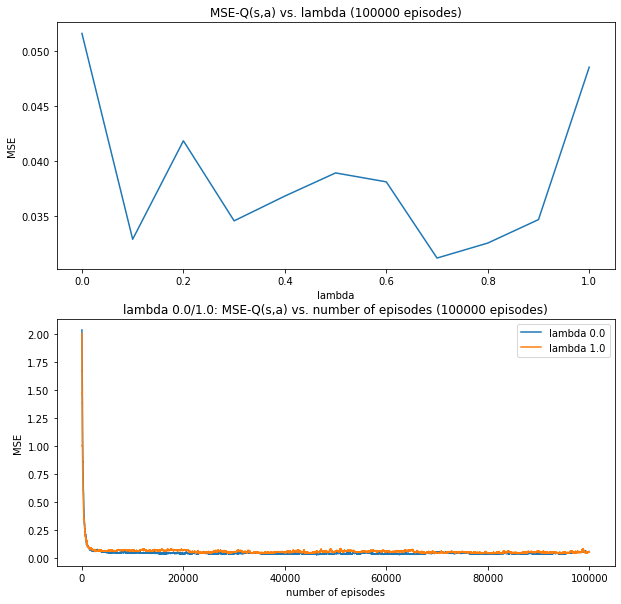

In [26]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(211)
ax1.plot([t[0] for t in sarsa_lfa_results], [t[2][-1] for t in sarsa_lfa_results])
ax1.set_title(f'MSE-Q(s,a) vs. lambda ({n_episodes} episodes)')
ax1.set_xlabel('lambda')
ax1.set_ylabel('MSE')

ax2 = fig.add_subplot(212)
ax2.plot(range(1, n_episodes+1), sarsa_lfa_results[0][2], label='lambda 0.0')
ax2.plot(range(1, n_episodes+1), sarsa_lfa_results[-1][2], label='lambda 1.0')
ax2.set_title(f'lambda 0.0/1.0: MSE-Q(s,a) vs. number of episodes ({n_episodes} episodes)')
ax2.set_xlabel('number of episodes')
ax2.set_ylabel('MSE')

plt.legend(loc='upper right')
plt.show()